<a href="https://colab.research.google.com/github/Ryleigh-Harvey/portfolio/blob/main/Machine_Learning_Project_2_Ryleigh_and_James.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project - Workout Recommender
### By: Ryleigh Harvey and James Maduako




Client's Request: Can you provide and recommend personalized workouts for different sports like boxing, wrestling, bodybuilding, powerlifting, and jiu-jitsu based on a user’s progress and feedback using reinforcement learning?

**Introduction:**

The goal of this project is to develop a machine learning-based workout recommender system. This system leverages both content-based filtering  and collabrative filtering. The dataset used in this project was created by us specifically to ensure that the system reflects particular user behaviors and workout preferences requested by our cilent. By building our own dataset, we were able to capture detailed user information, such as fitness level, workout type, and personal workout history. This allows for more accurate and personalized recommendations that cater to the unique needs of users.

The dataset includes 'user_id', 'sport',  'fitness_level', 'goal', 'workout_type', 'duration', 'intensity', 'complete', 'reps_or_time', 'weight_lifted', 'satisfaction', 'fatigue', 'soreness', 'date','next_suggested_workout', 'reward', 'heart_rate', 'calories_burned', 'user_history', 'rating', enabling personalized workout suggestions.

In [ ]:
#Import necessary libraries
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Mount Google Drive to access the dataset
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/workout_data-3.csv')

#rename columns
data.columns = ['user_id','sport', 'fitness_level', 'goal', 'workout_type','duration',
                'intensity','complete','reps_or_time','weight_lifted','satisfaction','fatigue',
                'soreness','date','next_suggested_workout','reward','heart_rate','calories_burned','user_history', 'rating']

# Extracting user_id, workout_type, and rating columns for matrix creation later
ratings = data[['user_id', 'workout_type', 'rating']]

# Displaying the dataset
data.head()

Mounted at /content/drive


,user_id,sport,fitness_level,goal,workout_type,duration,intensity,complete,reps_or_time,weight_lifted,satisfaction,fatigue,soreness,date,next_suggested_workout,reward,heart_rate,calories_burned,user_history,rating
0,196,Wrestling,Intermediate,Endurance,Mat Work,61,3,True,12,NaN,4,2,False,2024-02-12,Conditioning,2,134,1366.577372,"['Incline Dumbbell Press', 'Bench Press', 'Acc...",2
1,72,Bodybuilding,Advanced,Endurance,Incline Dumbbell Press,64,3,True,15,107.0,1,2,True,2024-09-16,Bench Press,-1,94,1215.805702,"['Deadlift', 'Conditioning', 'Bench Press', 'D...",1
2,112,Jiu-Jitsu,Intermediate,Strength,Rolling,45,3,True,25,NaN,2,5,False,2024-03-12,Flexibility Training,-3,124,917.937847,"['Drills', 'Accessory Work', 'Bag Work', 'Benc...",1
3,370,Wrestling,Advanced,Strength,Mat Work,99,2,True,7,NaN,5,3,True,2024-03-02,Mat Work,2,173,1354.288794,"['Bag Work', 'Incline Dumbbell Press', 'Shadow...",2
4,12,Bodybuilding,Beginner,Endurance,Incline Dumbbell Press,101,3,False,28,141.0,2,4,False,2024-08-01,Squat,-2,175,2079.166436,"['Squat', 'Sparring', 'Flexibility Training', ...",1


In [ ]:
data.shape #showing the shape of the dataset

(5000, 20)

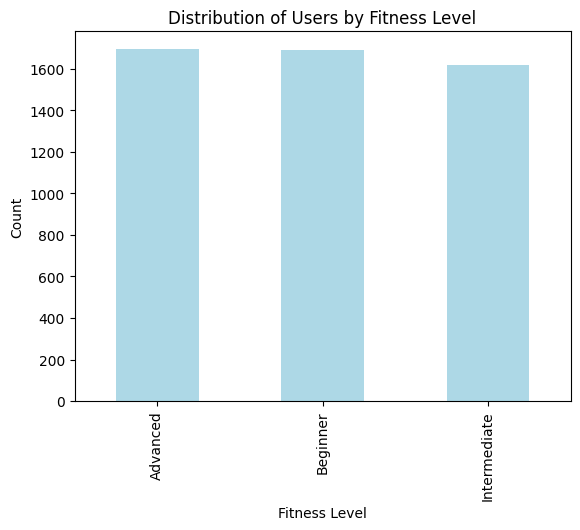

In [ ]:
# Plot the distribution of the fitness levels among the users
data['fitness_level'].value_counts().plot(kind='bar', color='lightblue')
plt.title('Distribution of Users by Fitness Level')
plt.xlabel('Fitness Level')
plt.ylabel('Count')
plt.show()

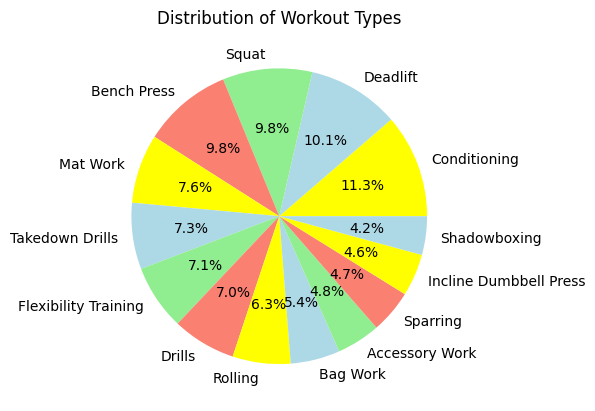

In [ ]:
# Plot the distribution of workout types in the dataset
data['workout_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['yellow','lightblue', 'lightgreen', 'salmon'])
plt.title('Distribution of Workout Types')
plt.ylabel('')
plt.show()


## Methods and Approaches
The workout recommender system employs two primary recommendation techniques: content-based filtering and collaborative filtering.

- Content-Based Filtering:

  This approach assumes that users who liked certain workouts in the past are likely to enjoy similar ones in the future, especially workouts that match their specific sport or criteria. This method is simple and effective, ensuring that recommentaions are personalized based on a user's characteristics and goals. One major limiataion of conetnt-based filering is that it can only recommed=nd workouts that match the user;s current perfernces,and may not expose users to new or diverse workouts outside their typical choices. It dependent on having accurate and sufficient metadata for each workout.

- Collaborative Filtering:

  This approach uses the concept of user similarity to recommend workouts based on the behavior or preferences of similar users. The system analyzes the user history, such as previousy completed workouts, and computes similarity scores using techniques like cosine similarity or nearest neighbors. One possible limaitaion would be the system struggling to make recommendations for new users or items because of insufficient interaction data.

- Combining Methods:

  By combining both content-based and collaborative filtering methods, the system benefits from hybridization, addressing some of the individual weaknesses of each technique.This method can allow more robust and diverse recommendations,while also producing more accurate and varied recommendations. Potential issues could be redundancy.

- Matrix-Based Collaborative Filtering:

  This approach constructs a user-item rating matrix, enabling a Nearest Neighbors model to find similar workouts. It recommends workouts based on user similarity scores from the matrix, allowing fine-tuned recommendations based on user feedback and ratings.

**Content-Based Filtering**

In [ ]:
# Content-based Recommender Function
def content_based_recommender(user_id, data):
    user_data = data[data['user_id'] == user_id]
    fitness_level = user_data.iloc[0]['fitness_level']
    workout_type = user_data.iloc[0]['workout_type']

    # Filter dataset for workouts matching user's fitness level and workout preference
    recommended_workouts = data[(data['fitness_level'] == fitness_level) &
                              (data['workout_type'] == workout_type)]
    return recommended_workouts

In [ ]:
#Testing the recommenders with user ID 1
content_recs = content_based_recommender(data['user_id']==1 ,data)
print(content_recs)

      user_id      sport fitness_level                   goal  workout_type  \
10        396  Wrestling  Intermediate               Strength  Conditioning   
105       113     Boxing  Intermediate  Technique Improvement  Conditioning   
150       105  Wrestling  Intermediate            Hypertrophy  Conditioning   
156       165  Wrestling  Intermediate               Strength  Conditioning   
190       329     Boxing  Intermediate            Hypertrophy  Conditioning   
...       ...        ...           ...                    ...           ...   
4841      165     Boxing  Intermediate              Endurance  Conditioning   
4842      105  Wrestling  Intermediate               Strength  Conditioning   
4854      186  Wrestling  Intermediate               Strength  Conditioning   
4872      245     Boxing  Intermediate  Technique Improvement  Conditioning   
4984      305  Wrestling  Intermediate            Hypertrophy  Conditioning   

      duration  intensity  complete  reps_or_time  

**Collaborative Filtering**

In [ ]:
# Collaborative filtering - User Similarity Based Recommender
def collaborative_recommender(user_id, data):
    # Convert user history inro a format suitable for similarity calculation
    tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
    tfidf_matrix = tfidf.fit_transform(data['user_history'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Identify the index of  the user in the dataset
    user_index = data.index[data['user_id'] == user_id][0]

    # Sort similarity scores and select top similar users
    sim_scores = list(enumerate(cosine_sim[user_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    similar_users = [i[0] for i in sim_scores[1:3]]  # Get top 2 similar users
    recommended_workouts = data.iloc[similar_users]
    return recommended_workouts

In [ ]:
collab = collaborative_recommender(data['user_id']==1 ,data)
print(collab)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


      user_id         sport fitness_level                   goal  \
1692      163        Boxing      Advanced  Technique Improvement   
1048      155  Bodybuilding      Advanced              Endurance   

      workout_type  duration  intensity  complete  reps_or_time  \
1692  Conditioning        58          4      True            16   
1048         Squat        49          4      True             5   

      weight_lifted  satisfaction  fatigue  soreness        date  \
1692            NaN             2        2     False  2024-06-03   
1048          101.0             2        5     False  2024-12-10   

     next_suggested_workout  reward  heart_rate  calories_burned  \
1692           Conditioning       0          99      1234.115836   
1048            Bench Press      -3          95       989.518416   

                                           user_history  rating  
1692  ['Bag Work', 'Accessory Work', 'Takedown Drill...       1  
1048  ['Deadlift', 'Mat Work', 'Bench Press', 'Bag 

**Combining methods**


In [ ]:
#Combined Recommender Function
def recommend_workouts(user_id, data):
    # Get recommendations from both methods
    content_recs = content_based_recommender(user_id, data)
    collab_recs = collaborative_recommender(user_id, data)

    # Combine recommendations, removing duplicates
    combined_recs = pd.concat([content_recs, collab_recs]).drop_duplicates()
    return combined_recs


**Matrix-Based Collaborative Filtering**

In [ ]:
# Recommendation for similar workouts based on workout_id
def find_similar_workouts(workout_id, X, k=5, metric='cosine', show_distance=False):
    workout_ind = workout_mapper[workout_id]
    workout_vec = X[workout_ind]
    # Nearest Neighbor model for similar workout recommendations
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    workout_vec = workout_vec.reshape(1, -1)
    neighbour = kNN.kneighbors(workout_vec, return_distance=show_distance)

    neighbour_ids = [workout_inv_mapper[neighbour[1][0][i]] for i in range(1, k+1)]
    return neighbour_ids

In [ ]:
# Matrix Creation Function for Collabrative Filtering
def create_matrix(data):
  # Mapping user and workout IDs for matrix construction
    user_mapper = {user: idx for idx, user in enumerate(data['user_id'].unique())}
    workout_mapper = {workout: idx for idx, workout in enumerate(data['workout_type'].unique())}
    user_inv_mapper = {v: k for k, v in user_mapper.items()}
    workout_inv_mapper = {v: k for k, v in workout_mapper.items()}

  # Matrix indices based on user and workout mapping
    user_index = [user_mapper[i] for i in data['user_id']]
    workout_index = [workout_mapper[i] for i in data['workout_type']]

  # Create a sparse matrix of ratings
    X = csr_matrix((data["rating"], (workout_index, user_index)), shape=(len(workout_mapper), len(user_mapper)))
    return X, user_mapper, workout_mapper, user_inv_mapper, workout_inv_mapper

# Generate the user-item matrix for collaborative filtering
X, user_mapper, workout_mapper, user_inv_mapper, workout_inv_mapper = create_matrix(ratings)


In [ ]:
# Recommend workouts for a user
def recommend_workouts_for_user(user_id, X, user_mapper, workout_mapper, workout_inv_mapper, k=10):
    user_ind = user_mapper[user_id]
    user_vec = X[:, user_ind].toarray().reshape(-1)
    # get top k recommended workout indices
    workout_indices = user_vec.argsort()[-k:][::-1]
    workout_ids = [workout_inv_mapper[i] for i in workout_indices]

    return workout_ids

In [ ]:
# Retrieve all unique user IDs from the dataset
user_ids = data['user_id'].unique()

# Create a dictionary mapping sport to workout_type from the dataset
workout_titles = dict(zip(data['sport'], data['workout_type']))

# Function to recommend and print workouts for multiple users
def recommend_workouts_for_multiple_users(user_ids, X, user_mapper, workout_inv_mapper, data, k=5):
    all_recommendations = {}

    for user_id in user_ids:
        # Check if the user exists in the user_mapper
        if user_id in user_mapper:
            recommended_workouts = recommend_workouts_for_user(user_id, X, user_mapper, workout_mapper, workout_inv_mapper, k)

            # Map workout IDs to titles using the data
            workout_names = [workout_titles.get(workout_id, f"Workout ID {workout_id}") for workout_id in recommended_workouts]
            all_recommendations[user_id] = workout_names

            # Retrieve the user's sport from the dataset
            user_sport = data.loc[data['user_id'] == user_id, 'sport'].iloc[0]
            # Print recommendations
            #print(f"\nRecommended Workouts for User ID {user_id} (Sport:{user_sport}):")
            #for workout_name in workout_names:
                #print(f"- {workout_name}")
                #print(workout_name)
        else:
            print(f"User ID {user_id} not found in the user_mapper.")

    return all_recommendations

# Generate and print recommendations for each user
all_recommendations = recommend_workouts_for_multiple_users(user_ids, X, user_mapper, workout_inv_mapper, data, k=5)


## Summary

**In summary**,

 this project aims to develop a user-friendly system  designed to enhance users' lifestyles and training routines. By leveraging personalized recommendations the system helps individuals make more informed decisions about their exercise regimens. The system also has the potential to support long-term fitness progress and improve overall well-being, making it a powerful tool for anyone looking to lead a healthier, more active lifestyle.

**Data Limitations and Improvements or Enhancements:**

A limitation could be that there may be inherent bias in the dataset, such as specific workouts being overrepresented.

An improvement would be additional features that are more user-specific, such as age, gender, or specific fitness goals. These aspects could further personalize recommendations. Another could be implementing feedback loops where users can rate or provide feedback on recommendations, allowing the system to learn and adapt in real-time to a user's preference.

**Conclusion:**

This workout recommender system provides personalized workout recommendations using a blend of content-based and collaborative filtering approaches. It is a versatile solution for users with different preferences and fitness levels, offering both similarity-based recommendations and attribute-based filtering. The model can be enhanced with features like feedback mechanisms, hybrid weighting, and diversified suggestions for a more dynamic and adaptable recommendation experience. The visualizations and added functionality make this system valuable for tracking user preferences and refining workout suggestions over time.